In [7]:
import torch
import matplotlib.pyplot as plt

EPSILON = 1e-3

# Define the SDE solver using the Euler-Maruyama method
def sde_solver(x0, s, a, b, dt, T, device='cpu'):
    B, D, K = x0.shape
    N = int(T / dt)  # number of time steps
    
    # Initialize the solution tensor
    x = torch.zeros((N, B, D, K), device=device)
    x[0] = x0
    
    # Precompute constants
    s_half = s / 2.0
    sqrt_dt = torch.sqrt(torch.tensor(dt, device=device))
    
    for n in range(1, N):
        # Compute the drift and diffusion terms
        drift = s_half[:,None,None] * (a[None,None,:] * (1 - x[n-1]) - b[None,None,:] * x[n-1])
        diffusion = torch.sqrt(s[:,None,None] * x[n-1] * (1 - x[n-1]))
        
        # Generate the Wiener process increments
        dW = torch.randn((B, D, K), device=device) * sqrt_dt
        
        # Update the solution
        x[n] = x[n-1] + drift * dt + diffusion * dW

        # Ensure values are within [0, 1]
        x[n] = torch.clamp(x[n], EPSILON, 1.0)
        # print(x)
        
    return x

# Stick-breaking function to map K-dimensional values to the simplex
def stick_breaking_process(x):
    x = torch.sigmoid(x)  # Ensure values are between 0 and 1
    remaining_stick = 1 - x
    remaining_stick = torch.cat([torch.ones_like(remaining_stick[:, :, :, :1]), remaining_stick], dim=-1)
    remaining_stick = torch.cumprod(remaining_stick[:, :, :, :-1], dim=-1)
    simplex_path = x * remaining_stick
    simplex_path[:, :, :, -1] = 1.0 - torch.sum(simplex_path[:, :, :, :-1], dim=-1)
    return simplex_path

# Plotting function
def plot_trajectory(simplex_path, B_index, D_index, dt):
    N = simplex_path.shape[0]
    T = N * dt
    time = torch.arange(0, T, dt)
    
    plt.figure(figsize=(10, 6))
    for K_index in range(simplex_path.shape[-1]):
        trajectory = simplex_path[:, B_index, D_index, K_index].cpu().numpy()
        plt.plot(time, trajectory, label=f'Trajectory for B={B_index}, D={D_index}, K={K_index}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('SDE Solution Trajectory over Simplex')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# Parameters
B, D, K = 10000, 2, 20  # Example dimensions
x0 = torch.rand((B, D, K))  # Initial condition
s = 1. * torch.rand(B)
a = torch.full((K,),2.) # Different a for each K
# b = torch.full((K,),5.) # Different a for each K
b = torch.arange(1,K+1,1)  # Different b for each K
dt = 0.01
T = 1.0

print(a)
print(b)

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2.])
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20])


torch.Size([1000, 10000, 2, 20])


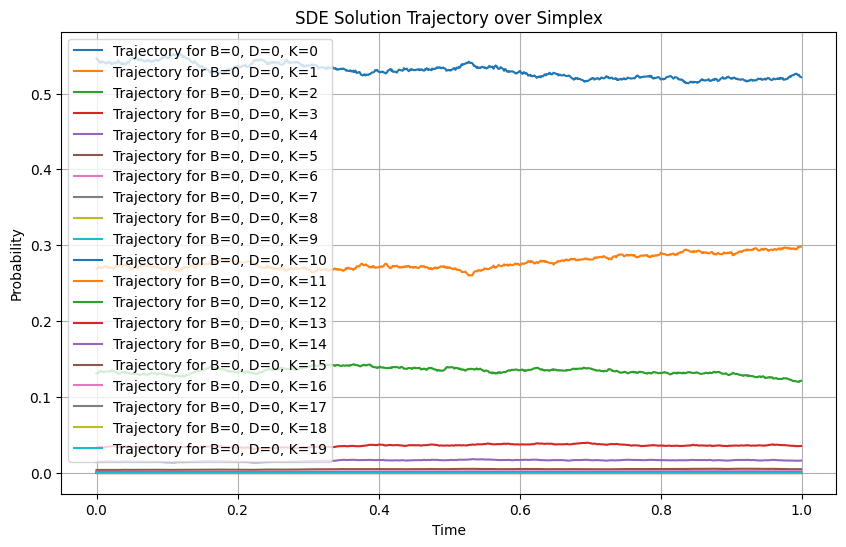

In [12]:
# Solve the SDE
solution = sde_solver(x0, s, a, b, dt, T)
print(solution.shape)

# Apply stick-breaking process to map the trajectory to the simplex
simplex_path = stick_breaking_process(solution)

# Plot the trajectory for chosen B and D indices over the simplex
plot_trajectory(simplex_path, B_index=0, D_index=0, dt=dt)


# Check for Stationarity

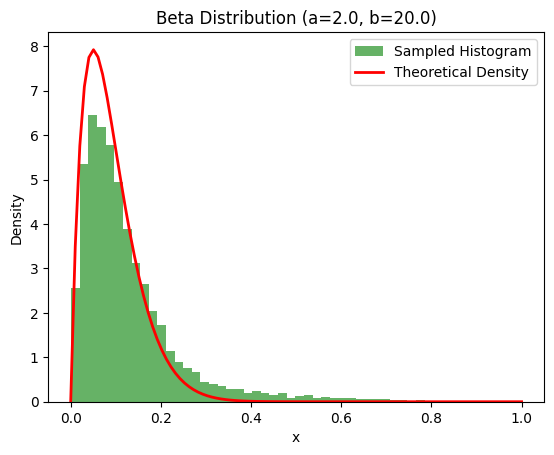

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Parameters for the Beta distribution
a = 2.0
b = 20.

# Number of samples to draw
num_samples = 10000

# Draw samples from the Beta distribution
#samples = torch.distributions.Beta(a, b).sample((num_samples,))
samples = solution[-1,:,1,19]

# Convert samples to numpy array for plotting
samples_np = samples.numpy()

# Plot the histogram of the samples
plt.hist(samples_np, bins=50, density=True, alpha=0.6, color='g', label='Sampled Histogram')

# Plot the theoretical Beta distribution density
x = np.linspace(0, 1, 100)
y = beta.pdf(x, a, b)
plt.plot(x, y, 'r-', lw=2, label='Theoretical Density')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Beta Distribution (a={a}, b={b})')
plt.legend()

# Show the plot
plt.show()